In [1]:
'''
=========================================================================
OSE bootcamp 2019
Week 5, [ Scott Condie's lecture ]
Problem Set 1 : Asset Pricing and GMM
[ Based on Lucas(1978), Hansen & Singleton (1982) ]

By Dohan Kim (UPenn), 2019 August
=========================================================================
'''

# pip install pandas_datareader

import numpy as np
import pandas as pd
import scipy.optimize as opt
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import pandas_datareader.data as web
import datetime

### Data

In [2]:
def import_data(start, end, freq='Q'):
    '''
    This function imports data from Fred series
    
    [ Parameters ]
        start : start date (year, month, day) ex) start = datetime.datetime(1970, 1, 1)
        end   : end date   (year, month, day) ex) end = datetime.datetime(2018, 12, 31)
        freq  : frequency of the data (default=quarterly)
    
    [ Return ]
        data : [ PCECC96, WILL5000INDFC, GDPDEF, TB3MS ]
            1) PCECC96       : real personal conumption expenditures
            
            2) WILL5000INDFC : returns to the aggregate US stock market (Wilshire 5000)
            3) GDPDEF        : GDP deflator (measure of inflation)
            4) TB3MS         : 3-month T-Bill rate (measure of risk free rate)
    '''
    
    data = web.DataReader(['PCECC96', 'WILL5000INDFC', 'GDPDEF', 'TB3MS'], 'fred', start, end)
    data = data.groupby(pd.PeriodIndex(data.index, freq=freq)).mean()
    
    return data

In [3]:
# time period
start = datetime.datetime(1970, 9, 30)
end = datetime.datetime(2018, 12, 31)

# import the data and name the columns
data = import_data(start, end, freq='Q')
data.columns = ['cons', 'market_index', 'deflator', 'rf']

# compute the real returns
data['market_index_def'] = data['market_index'] / data['deflator']
data['R'] = data['market_index_def'] / data['market_index_def'].shift(1)
data['rf'] = (1 + (data['rf']-1) / 4) / 100  # annual data to quarter data

# drop unnecessary columns
data.drop(['market_index_def'], axis=1, inplace=True)

# check the data
data

,cons,market_index,deflator,rf,R
DATE,,,,,
1970Q4,3097.520,1.000000,22.056,0.020883,NaN
1971Q1,3156.978,1.080000,22.391,0.017100,1.063842
1971Q2,3185.993,1.136667,22.685,0.018125,1.038829
1971Q3,3211.394,1.113333,22.916,0.020025,0.969599
1971Q4,3264.679,1.113333,23.107,0.018075,0.991734
1972Q1,3307.767,1.240000,23.458,0.016092,1.097107
1972Q2,3370.736,1.280000,23.604,0.016925,1.025873
1972Q3,3422.682,1.293333,23.830,0.018050,1.000834
1972Q4,3503.001,1.356667,24.134,0.019658,1.035756


### Object

In [4]:
class AssetPricing_GMM:
    
    def __init__(self, df, β):
        self.df = df   # df = data
        self.β = β
        
    def condition_q1(self, γ):
        self.df['m'] = self.β * (self.df['cons'].shift(-1) / self.df['cons']) ** (-γ)
        m = self.df['m']
        R = self.df['R']
        error = 1 - np.cov(m[1:-1], R[1:-1])[0,1] - m[1:-1].mean() * R[1:-1].mean()
        return error
    
    def condition_q2(self, γ):
        self.df['m'] = self.β * (self.df['cons'].shift(-1) / self.df['cons']) ** (-γ)
        m = self.df['m']
        rf = self.df['rf']
        error = 1 - (1 + rf[1:-1].mean()) * m[1:-1].mean()  
        return error
    
    def condition_q3(self, params):
        γ, β = params
        self.df['m'] = β * (self.df['cons'].shift(-1) / self.df['cons']) ** (-γ)
        m = self.df['m']
        R = self.df['R']
        rf = self.df['rf']
        eq = np.empty(len(params))
        eq[0] = 1 - np.cov(m[1:-1], R[1:-1])[0,1] - m[1:-1].mean() * R[1:-1].mean()
        eq[1] = 1 - (1 + rf[1:-1].mean()) * m[1:-1].mean()
        Weight = np.eye(len(eq))
        error = eq.T @ Weight @ eq
        return error
        
    def estimation(self, method):
        if method == 1:
            params = opt.broyden1(self.condition_q1, 1)
        elif method == 2:
            params = opt.broyden1(self.condition_q2, 1)
        elif method == 3:
            params = opt.minimize(self.condition_q3, [1, 0.9], bounds=((1e-5, None), (0.1, 1))).x
        else:
            raise ValueError("method should be 1, 2, or 3 !")
        return params

### Problem 1

In [5]:
β = 0.99
model = AssetPricing_GMM(data, β)
γ = model.estimation(method=1)
print("The estimated γ = %4.3f" % γ)

The estimated γ = 1.243


### Problem 3

In [6]:
γ = model.estimation(method=2)
print("The estimated γ = %4.3f" % γ)

The estimated γ = 1.208


### Problem 4

In [7]:
γ, β = model.estimation(method=3)
print("The estimated γ = %4.3f" % γ)
print("The estimated β = %4.3f" % β)

The estimated γ = 0.998
The estimated β = 0.988


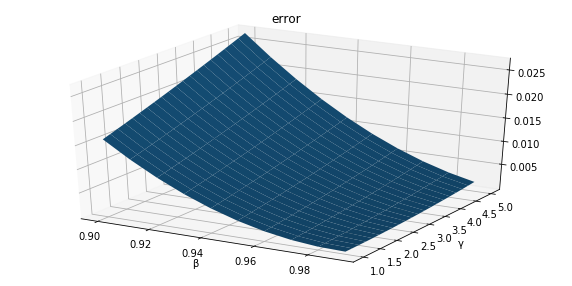

In [8]:
# Plot the errors for different (β,γ) pairs

nβ, nγ = 10, 21
βgrid = np.linspace(0.9, 0.99, nβ)
γgrid = np.linspace(1, 5, nγ)

error = np.empty((nβ, nγ))
for iβ in range(nβ):
    β = βgrid[iβ]
    for iγ in range(nγ):
        γ = γgrid[iγ]
        error[iβ, iγ] = model.condition_q3([γ, β])

fig = plt.figure(figsize = [10, 5])
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(np.reshape(βgrid, (nβ,1)), γgrid, error)
plt.xlabel("β"); plt.ylabel("γ"); plt.title("error")
plt.show()

### End